In [1]:
# ideas for a source test
import cobra
import pandas as pd

from refinegems.utility.io import load_model

/Users/brune/miniconda3/envs/sprg/lib/python3.10/site-packages/pydantic/_internal/_config.py:322: UserWarning: Valid config keys have changed in V2:
* 'underscore_attrs_are_private' has been removed
  warnings.warn(message, UserWarning)


In [2]:
test_model_path = '/Users/brune/Documents/11_Test_Data/test_SPECIMEN/thesis/Kp_std/03_refinement/step4-smoothing/Kp_std_smooth.xml'
test_model = load_model(test_model_path,'cobra')


-----
### Plot the basic analysis

- one model  -  done more or less
- collection of models

#### Plot for a single report

/Users/brune/miniconda3/envs/sprg/lib/python3.10/site-packages/pydantic/_internal/_config.py:322: UserWarning: Valid config keys have changed in V2:
* 'underscore_attrs_are_private' has been removed
  warnings.warn(message, UserWarning)
/Users/brune/miniconda3/envs/sprg/lib/python3.10/site-packages/cobra/core/metabolite.py:129: UserWarning: invalid character '*' found in formula 'HO*'
  warn(f"invalid character '*' found in formula '{self.formula}'")
/Users/brune/miniconda3/envs/sprg/lib/python3.10/site-packages/cobra/core/metabolite.py:129: UserWarning: invalid character '*' found in formula 'C8H14NOS2*'
  warn(f"invalid character '*' found in formula '{self.formula}'")
/Users/brune/miniconda3/envs/sprg/lib/python3.10/site-packages/cobra/core/metabolite.py:129: UserWarning: invalid character '*' found in formula 'HO2*'
  warn(f"invalid character '*' found in formula '{self.formula}'")
/Users/brune/miniconda3/envs/sprg/lib/python3.10/site-packages/cobra/core/metabolite.py:129: UserWarn

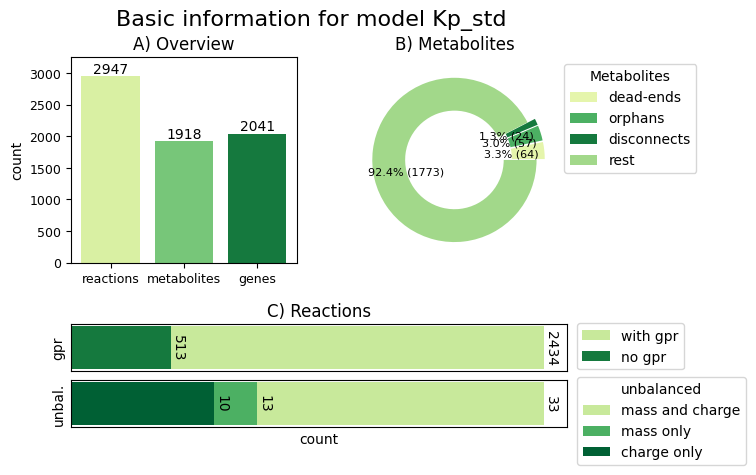

In [1]:
from refinegems.utility.io import load_model
from refinegems.classes.reports import ModelInfoReport
import matplotlib.pyplot as plt

test_model_path = '/Users/brune/Documents/11_Test_Data/test_SPECIMEN/thesis/Kp_std/03_refinement/step4-smoothing/Kp_std_smooth.xml'
test_model = load_model(test_model_path,'cobra')

rep = ModelInfoReport(test_model)
fig = rep.visualise()

plt.show()

#### Plot growth heatmap

In [1]:
from refinegems.classes.reports import GrowthSimulationReport, SingleGrowthSimulationReport

import pandas as pd

/Users/brune/miniconda3/envs/sprg/lib/python3.10/site-packages/pydantic/_internal/_config.py:322: UserWarning: Valid config keys have changed in V2:
* 'underscore_attrs_are_private' has been removed
  warnings.warn(message, UserWarning)


In [2]:
testfile = '/Users/brune/Documents/11_Test_Data/test_refinegems/test_growth_heatmap.tsv'

data = pd.read_csv(testfile, sep='\t')
data.head()

,model,medium,doubling_time [min],growth_value,complete
0,iShJCSC1435GOG23,VMH1,7.760722,5.358887,"EX_asn__L_e, EX_asn__L_e, EX_asn__L_e, EX_asn_..."
1,iShJCSC1435GOG23,VMH2,6.562501,6.337345,"EX_asn__L_e, EX_asn__L_e, EX_asn__L_e, EX_asn_..."
2,iShJCSC1435GOG23,CoreJCSC1435,8.383171,4.960990,"EX_asn__L_e, EX_asn__L_e, EX_asn__L_e, EX_asn_..."
3,iShJCSC1435GOG23,LB,57.578721,0.722295,"EX_asn__L_e, EX_asn__L_e, EX_asn__L_e, EX_asn_..."
4,iShJCSC1435GOG23,RPMI,inf,0.000000,"EX_asn__L_e, EX_asn__L_e, EX_asn__L_e, EX_asn_..."


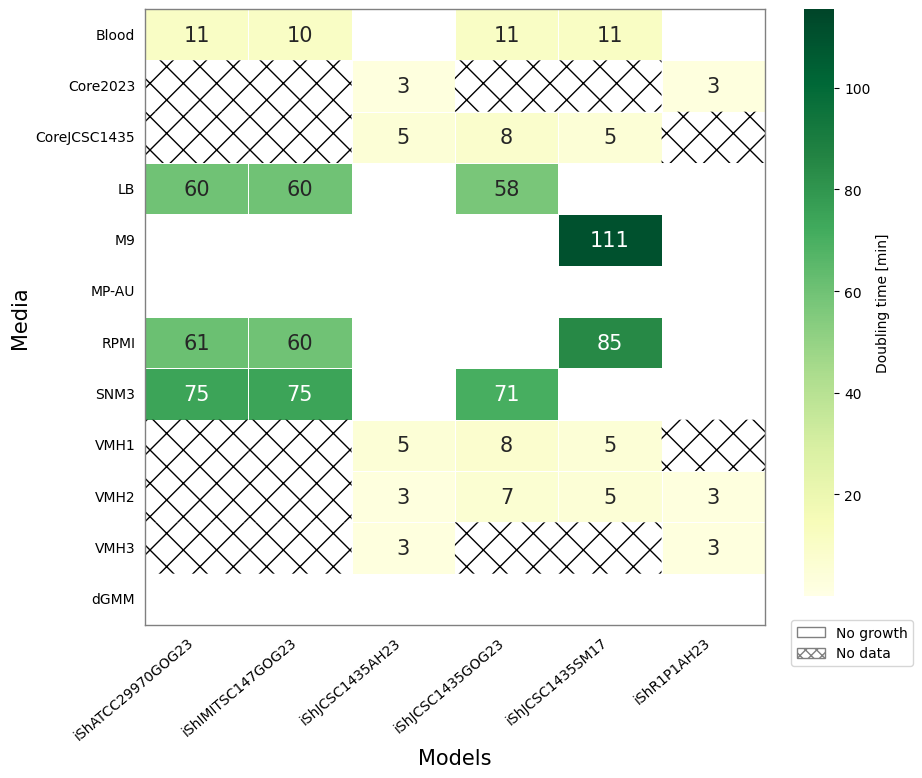

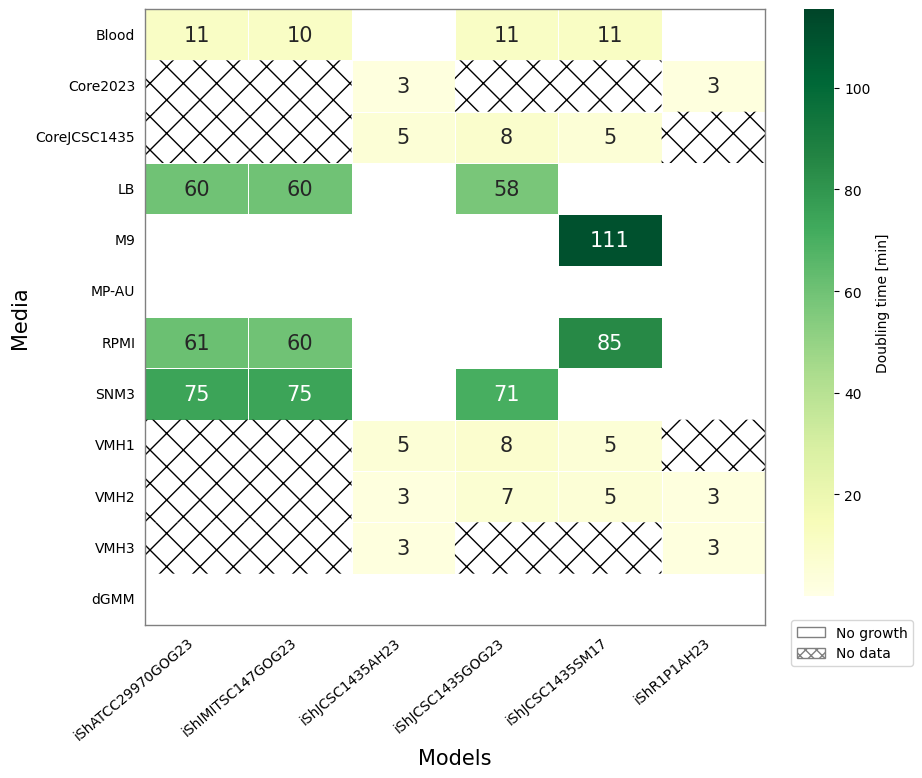

In [3]:
report = GrowthSimulationReport()

for idx in range(0,len(data)):
    temp = SingleGrowthSimulationReport(data.iloc[idx,0],
                                        data.iloc[idx,1],
                                        data.iloc[idx,3],
                                        data.iloc[idx,2])
    
    report.add_sim_results(temp)

report.plot_growth()

In [1]:
from refinegems.classes import egcs

AttributeError: partially initialized module 'refinegems' has no attribute 'classes' (most likely due to a circular import)